## End-to-End Llama 4 Mixture-of-Experts (MoE) Text Model Implementation (Inline)

### Introduction: Exploring Llama 4's MoE Architecture

This notebook provides a detailed, step-by-step implementation of a simplified text generation model based on the concepts found in advanced architectures like Llama 4, with a specific focus on the **Mixture-of-Experts (MoE)** component. We aim to understand how MoE layers operate within a Transformer framework.

**Key Concepts from Llama 4 Implemented Here:**

1.  **Transformer Core:** The fundamental building blocks remain the Transformer architecture (Self-Attention, Feed-Forward layers).
2.  **RMSNorm:** Root Mean Square Normalization is used instead of standard Layer Normalization.
3.  **Rotary Positional Embeddings (RoPE):** To inject sequence order information directly into the attention mechanism.
4.  **Mixture-of-Experts (MoE):** Replacing some standard Feed-Forward layers with MoE blocks. Each MoE block contains:
    *   Multiple smaller "expert" networks (MLPs).
    *   A "router" network that learns to direct each input token to a small subset (Top-K) of these experts.
    *   A mechanism to combine the outputs from the selected experts.
    *   Often includes a "shared" expert (a standard MLP) whose output is combined with the MoE output.
5.  **Gated MLP:** The expert MLPs (and the shared expert) use a gated activation (like SiLU) similar to standard Llama models.

**Simplifications for this Inline Implementation:**

*   **Attention:** We will implement standard Multi-Head Attention (MHA) for simplicity, although Llama models often use optimizations like Grouped Query Attention (GQA).
*   **Scale:** We will use significantly smaller dimensions (`d_model`, `n_layers`, number of experts) and a smaller dataset (character-level tokenization on a small text corpus) for feasibility.
*   **Optimizations:** Features like L2 Norm on queries/keys, temperature tuning, and chunked attention are omitted to focus on the core MoE structure.

**Style:**

Following the requested style, this implementation uses:
*   Small, sequential code blocks.
*   Detailed theoretical explanations before each block.
*   Inline execution (minimal use of functions/classes).
*   `print` statements to show intermediate shapes and values.

Let's begin by setting up the environment.

### Step 0: Setup - Libraries, Seed, and Device

**Goal:** Prepare the environment by importing necessary libraries (PyTorch for tensor operations and neural networks, math for calculations) and setting up for reproducibility and hardware selection.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import math
import os
import collections # For BPE-like processing if extended
import re          # For initial splitting

# For reproducibility
torch.manual_seed(1337)

print(f"PyTorch version: {torch.__version__}")

# --- Device Configuration ---
# Theory: Set the device (GPU 'cuda' if available, else CPU) for tensor operations.
# This ensures models and data are processed efficiently on available hardware.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")
print("Libraries imported and device configured.")

PyTorch version: 2.6.0+cu124
Using device: cuda
Libraries imported and device configured.


**Output Explanation:** The code imports PyTorch and other standard libraries. It sets a random seed for reproducibility and checks if a CUDA-enabled GPU is available, setting the `device` variable accordingly. The output confirms the PyTorch version and the device being used (e.g., 'cuda' or 'cpu').

### Step 1: Corpus Definition and Character-Level Tokenization

**Goal:** Define the text data we will use for training and create a simple character-level tokenizer.

#### Step 1.1: Define the Training Corpus

**Theory:** We need some text data to train our language model. For simplicity and demonstration, we'll use a small excerpt from Lewis Carroll's "Alice's Adventures in Wonderland". A real model would be trained on vastly larger datasets.

In [2]:
# Define the raw text corpus for training
corpus_raw = """
Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Alice 'without pictures or
conversation?'
So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure
of making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a White Rabbit with pink eyes ran
close by her.
"""

print(f"Training corpus defined (length: {len(corpus_raw)} characters).")

Training corpus defined (length: 593 characters).


**Output Explanation:** This defines the `corpus_raw` string variable containing our sample text and prints its total character length.

#### Step 1.2: Character-Level Tokenization

**Theory:** We'll create the simplest form of tokenizer. We find all unique characters present in the corpus. Then, we create two dictionaries: `char_to_int` maps each unique character to a unique integer ID, and `int_to_char` provides the reverse mapping. The total number of unique characters determines our vocabulary size (`vocab_size`).

In [3]:
# Find all unique characters in the raw corpus
chars = sorted(list(set(corpus_raw)))
vocab_size = len(chars)

# Create character-to-integer mapping (encoding)
char_to_int = { ch:i for i,ch in enumerate(chars) }

# Create integer-to-character mapping (decoding)
int_to_char = { i:ch for i,ch in enumerate(chars) }

print(f"Created character vocabulary of size: {vocab_size}")
print(f"Vocabulary: {''.join(chars)}")
# Optional: Print mappings
# print(f"Char-to-Int mapping sample: {{k: char_to_int[k] for k in list(char_to_int)[:5]}}")
# print(f"Int-to-Char mapping sample: {{k: int_to_char[k] for k in list(int_to_char)[:5]}}")

Created character vocabulary of size: 36
Vocabulary: 
 '(),-.:?ARSWabcdefghiklmnoprstuvwy


**Output Explanation:** The code identifies all unique characters, calculates the `vocab_size`, and creates the forward (`char_to_int`) and reverse (`int_to_char`) lookup tables. The output shows the vocabulary size and the characters included.

#### Step 1.3: Encode the Corpus

**Theory:** Convert the entire raw text corpus into a sequence of integer token IDs using the `char_to_int` mapping. This numerical sequence is the actual input the model will process. We store this as a PyTorch tensor.

In [4]:
# Encode the entire corpus into a list of integer IDs
encoded_corpus = [char_to_int[ch] for ch in corpus_raw]

# Convert the list into a PyTorch tensor
full_data_sequence = torch.tensor(encoded_corpus, dtype=torch.long, device=device)

print(f"Encoded corpus into a tensor of shape: {full_data_sequence.shape}")
# Optional: Display first few encoded IDs
# print(f"First 50 encoded token IDs: {full_data_sequence[:50].tolist()}")

Encoded corpus into a tensor of shape: torch.Size([593])


**Output Explanation:** The raw corpus string is converted into a PyTorch tensor where each character is replaced by its integer ID. The output shows the shape of this tensor (which should be `[corpus_length]`).

### Step 2: Define Hyperparameters

**Goal:** Set the configuration values that control the size, structure, and training of our Llama 4-like MoE model. We reference the configuration from the provided Llama 4 script but scale down the dimensions significantly for this demonstration.

In [5]:
# --- Model Architecture Hyperparameters ---
# vocab_size is already determined from the data
d_model = 128         # Embedding dimension (reduced significantly)
n_layers = 4          # Number of Transformer blocks (reduced)
n_heads = 4           # Number of attention heads
block_size = 64       # Maximum context length (sequence length)
rms_norm_eps = 1e-5   # Epsilon for RMSNorm stability
rope_theta = 10000.0  # Theta parameter for RoPE (reduced from Llama 4's 500k)

# --- MoE Specific Hyperparameters ---
num_local_experts = 4      # Number of experts per MoE layer (reduced from 16)
num_experts_per_tok = 2   # Number of experts to route each token to (Top-K, reduced from 4?)
intermediate_size_expert = d_model * 2  # Hidden dimension within each expert MLP (scaled down)
intermediate_size_shared = d_model * 2  # Hidden dimension within the shared MLP (scaled down)

# --- Attention Hyperparameters ---
# d_k (dimension per head) will be derived from d_model and n_heads

# --- Training Hyperparameters ---
learning_rate = 5e-4  # Learning rate
batch_size = 16       # Number of sequences processed in parallel
epochs = 3000         # Number of training iterations (adjust as needed)
eval_interval = 300  # How often to print loss

# --- Derived Hyperparameters ---
assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
d_k = d_model // n_heads # Dimension of keys/queries/values per head
expert_dim = intermediate_size_expert # Alias for clarity
shared_expert_dim = intermediate_size_shared # Alias for clarity

print("--- Hyperparameters Defined ---")
print(f"Vocabulary Size (vocab_size): {vocab_size}")
print(f"Embedding Dimension (d_model): {d_model}")
print(f"Number of Layers (n_layers): {n_layers}")
print(f"Number of Attention Heads (n_heads): {n_heads}")
print(f"Dimension per Head (d_k): {d_k}")
print(f"Max Sequence Length (block_size): {block_size}")
print(f"RMSNorm Epsilon (rms_norm_eps): {rms_norm_eps}")
print(f"RoPE Theta (rope_theta): {rope_theta}")
print("--- MoE Specific ---")
print(f"Number of Local Experts (num_local_experts): {num_local_experts}")
print(f"Experts per Token (num_experts_per_tok): {num_experts_per_tok}")
print(f"Expert Intermediate Size (expert_dim): {expert_dim}")
print(f"Shared MLP Intermediate Size (shared_expert_dim): {shared_expert_dim}")
print("--- Training Specific ---")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")

--- Hyperparameters Defined ---
Vocabulary Size (vocab_size): 36
Embedding Dimension (d_model): 128
Number of Layers (n_layers): 4
Number of Attention Heads (n_heads): 4
Dimension per Head (d_k): 32
Max Sequence Length (block_size): 64
RMSNorm Epsilon (rms_norm_eps): 1e-05
RoPE Theta (rope_theta): 10000.0
--- MoE Specific ---
Number of Local Experts (num_local_experts): 4
Experts per Token (num_experts_per_tok): 2
Expert Intermediate Size (expert_dim): 256
Shared MLP Intermediate Size (shared_expert_dim): 256
--- Training Specific ---
Learning Rate: 0.0005
Batch Size: 16
Epochs: 3000


**Output Explanation:** This block defines and prints all the crucial hyperparameters governing the model's size (like `d_model`, `n_layers`, `n_heads`, `num_local_experts`), its behavior (like `rope_theta`, `rms_norm_eps`), and the training process (like `learning_rate`, `batch_size`, `epochs`). Derived values like `d_k` are also calculated and displayed.

### Step 3: Data Preparation for Training

**Goal:** Structure the encoded data (`full_data_sequence`) into input (`x`) and target (`y`) pairs suitable for training the next-token prediction task.

#### Step 3.1: Create Input (x) and Target (y) Pairs

**Theory:** The model learns to predict the next token based on the preceding ones. We create overlapping sequences of length `block_size` from our encoded corpus. For an input sequence `x` starting at index `i`, the corresponding target sequence `y` starts at index `i+1`. Each token in `y` is the target prediction for the corresponding token in `x`.

In [6]:
# Create lists to hold all possible input (x) and target (y) sequences
all_x = []
all_y = []

# Iterate through the encoded corpus tensor to extract overlapping sequences
num_total_tokens = len(full_data_sequence)
for i in range(num_total_tokens - block_size):
    # Extract the input sequence chunk
    x_chunk = full_data_sequence[i : i + block_size]
    # Extract the target sequence chunk (shifted one position right)
    y_chunk = full_data_sequence[i + 1 : i + block_size + 1]
    all_x.append(x_chunk)
    all_y.append(y_chunk)

# Stack the lists of tensors into single large tensors
train_x = torch.stack(all_x)
train_y = torch.stack(all_y)

num_sequences_available = train_x.shape[0]
print(f"Created {num_sequences_available} overlapping input/target sequence pairs.")
print(f"Shape of train_x: {train_x.shape}") # Should be (num_sequences, block_size)
print(f"Shape of train_y: {train_y.shape}") # Should be (num_sequences, block_size)

# Optional: Verify device
# print(f"train_x is on device: {train_x.device}") # May still be on CPU, move in batching

Created 529 overlapping input/target sequence pairs.
Shape of train_x: torch.Size([529, 64])
Shape of train_y: torch.Size([529, 64])


**Output Explanation:** The code extracts all possible sequences of length `block_size` and their corresponding target sequences from the encoded text. It then stacks these into two tensors, `train_x` and `train_y`. The output shows the number of sequence pairs created and their shapes.

#### Step 3.2: Batching Strategy (Random Sampling)

**Theory:** For training, we process data in batches. Instead of a formal DataLoader, we'll randomly sample `batch_size` indices from our available sequences (`0` to `num_sequences_available - 1`) in each training step. We then retrieve the corresponding sequences from `train_x` and `train_y` and move them to the correct `device`.

In [7]:
# Check if we have enough sequences for the desired batch size
if num_sequences_available < batch_size:
    print(f"Warning: Number of sequences ({num_sequences_available}) is less than batch size ({batch_size}). Adjusting batch size.")
    batch_size = num_sequences_available

print(f"Data ready for training. Will sample batches of size {batch_size} randomly.")
print("Batches will be moved to device during the training loop.")
# Example of how a batch would be selected in the loop:
# indices = torch.randint(0, num_sequences_available, (batch_size,))
# xb = train_x[indices].to(device)
# yb = train_y[indices].to(device)

Data ready for training. Will sample batches of size 16 randomly.
Batches will be moved to device during the training loop.


**Output Explanation:** Confirms the batching strategy. It checks if the batch size is feasible given the number of sequences and explains that random sampling will be used within the training loop to create batches.

### Step 4: Model Component Initialization (Inline)

**Goal:** Initialize the learnable parameters and fixed components for our Llama 4-like MoE model. We will store components for each layer in lists for use within the training loop.

#### Step 4.1: Token Embedding Layer

**Theory:** This layer maps discrete token IDs (our character IDs) to dense vectors of dimension `d_model`. It's essentially a lookup table where each row corresponds to a token in the vocabulary. Input shape `(B, T)` -> Output shape `(B, T, C)`, where `B` is batch size, `T` is sequence length (`block_size`), and `C` is embedding dimension (`d_model`).

In [8]:
# Initialize the token embedding table
token_embedding_table = nn.Embedding(vocab_size, d_model).to(device)

print(f"Initialized Token Embedding Layer:")
print(f"  Input Vocab Size: {vocab_size}")
print(f"  Output Embedding Dim (d_model): {d_model}")
print(f"  Weight shape: {token_embedding_table.weight.shape}")
print(f"  Device: {token_embedding_table.weight.device}")

Initialized Token Embedding Layer:
  Input Vocab Size: 36
  Output Embedding Dim (d_model): 128
  Weight shape: torch.Size([36, 128])
  Device: cuda:0


**Output Explanation:** Creates the `nn.Embedding` layer, specifying the vocabulary size and the desired embedding dimension (`d_model`). It's moved to the target `device`. The output confirms the layer's configuration and the shape of its learnable weight matrix (`vocab_size` x `d_model`).

#### Step 4.2: Rotary Positional Embedding (RoPE) Precomputation

**Theory:** RoPE injects positional information by rotating pairs of features in the query (Q) and key (K) vectors based on their absolute position. It uses complex numbers conceptually. We precompute the inverse frequencies (`inv_freq`) based on `rope_theta` and the dimension of each attention head (`d_k`). The actual rotation angles (`freqs_cis`) depend on the token positions and are calculated dynamically within the forward pass.
Formulas:
$$ \theta_i = \frac{1}{\text{rope_theta}^{2i / d_k}} $$
where $i \in [0, 1, ..., d_k/2 - 1]$. We precompute `inv_freq` which corresponds to this $\theta_i$.

In [9]:
# Precompute the inverse frequencies for RoPE
# Formula: 1.0 / (rope_theta ** (torch.arange(0, d_k, 2) / d_k))
rope_freq_indices = torch.arange(0, d_k, 2, dtype=torch.float, device=device)
inv_freq = 1.0 / (rope_theta ** (rope_freq_indices / d_k))

print("Precomputed RoPE inverse frequencies (inv_freq):")
print(f"  Shape: {inv_freq.shape}") # Should be (d_k / 2,)
print(f"  Values (first 5): {inv_freq[:5].tolist()}")
print(f"  Device: {inv_freq.device}")
# The 'freqs_cis' (complex numbers) will be computed in the forward pass using these inv_freq and position_ids

Precomputed RoPE inverse frequencies (inv_freq):
  Shape: torch.Size([16])
  Values (first 5): [1.0, 0.5623413324356079, 0.3162277638912201, 0.17782793939113617, 0.10000000149011612]
  Device: cuda:0


**Output Explanation:** This block calculates the `inv_freq` tensor based on the `rope_theta` and `d_k` hyperparameters. This tensor contains the fundamental frequencies used for RoPE. Its shape is `(d_k / 2,)`. The actual rotation values (`freqs_cis`) will be computed dynamically during the forward pass based on token positions.

#### Step 4.3: RMSNorm Layers Initialization

**Theory:** RMSNorm is a simplification of Layer Normalization. It normalizes the input by its root mean square and then scales it by a learnable weight parameter `gamma` (but typically lacks the learnable bias `beta` of LayerNorm).
Formula: $$ \text{RMSNorm}(x) = \frac{x}{\sqrt{\text{mean}(x^2) + \epsilon}} * \gamma $$
We need RMSNorm layers before the attention block, before the MoE/FFN block, and one final RMSNorm before the output layer.

In [10]:
# Lists to store RMSNorm layer weights for each Transformer block
rmsnorm_weights_input = []      # RMSNorm before MHA
rmsnorm_weights_post_attn = []  # RMSNorm before MoE/FFN

print(f"Initializing RMSNorm weights for {n_layers} layers...")
for i in range(n_layers):
    # RMSNorm weight for input to attention
    # Initialize weight as torch.ones, similar to nn.LayerNorm's default gamma
    weight_in = nn.Parameter(torch.ones(d_model, device=device))
    rmsnorm_weights_input.append(weight_in)

    # RMSNorm weight for input to MoE/FFN (post-attention)
    weight_post = nn.Parameter(torch.ones(d_model, device=device))
    rmsnorm_weights_post_attn.append(weight_post)
    print(f"  Initialized RMSNorm weights for Layer {i+1} (Input: {weight_in.shape}, PostAttn: {weight_post.shape})")

# Final RMSNorm before the output layer
final_rmsnorm_weight = nn.Parameter(torch.ones(d_model, device=device))

print(f"Initialized Final RMSNorm weight, shape: {final_rmsnorm_weight.shape}")
print("RMSNorm weights initialized (as nn.Parameter). The normalization logic will be inline.")

Initializing RMSNorm weights for 4 layers...
  Initialized RMSNorm weights for Layer 1 (Input: torch.Size([128]), PostAttn: torch.Size([128]))
  Initialized RMSNorm weights for Layer 2 (Input: torch.Size([128]), PostAttn: torch.Size([128]))
  Initialized RMSNorm weights for Layer 3 (Input: torch.Size([128]), PostAttn: torch.Size([128]))
  Initialized RMSNorm weights for Layer 4 (Input: torch.Size([128]), PostAttn: torch.Size([128]))
Initialized Final RMSNorm weight, shape: torch.Size([128])
RMSNorm weights initialized (as nn.Parameter). The normalization logic will be inline.


**Output Explanation:** Creates the learnable weight parameters (`gamma`) for each RMSNorm instance needed in the model (two per layer, plus one final). These are stored as `nn.Parameter` objects containing tensors initialized to ones, with shape `(d_model,)`. The actual normalization calculation will be performed inline during the forward pass using these weights.

#### Step 4.4: Attention Layers Initialization (MHA)

**Theory:** Initialize the linear projection layers needed for Multi-Head Attention within each Transformer block. We need:
1.  A combined projection layer to generate Query (Q), Key (K), and Value (V) vectors for all heads simultaneously. Input `(B, T, C)` -> Output `(B, T, 3*C)`.
2.  An output projection layer to combine the results from all heads back into the model dimension. Input `(B, T, C)` -> Output `(B, T, C)`.

In [11]:
# Lists to store Attention layers for each Transformer block
mha_qkv_linears = []    # Combined Linear layer for Q, K, V projections
mha_output_linears = [] # Output Linear layer for MHA

print(f"Initializing Attention (MHA) linear layers for {n_layers} layers...")
for i in range(n_layers):
    # Combined QKV projection layer
    # Bias is often False in large transformer QKV projections
    qkv_linear = nn.Linear(d_model, 3 * d_model, bias=False).to(device)
    mha_qkv_linears.append(qkv_linear)

    # Output projection layer
    # Bias is often False here too, but can be True
    output_linear = nn.Linear(d_model, d_model, bias=False).to(device)
    mha_output_linears.append(output_linear)
    print(f"  Initialized MHA Linears for Layer {i+1} (QKV: {qkv_linear.weight.shape}, Out: {output_linear.weight.shape})")

print("Attention (MHA) linear layers initialized.")

Initializing Attention (MHA) linear layers for 4 layers...
  Initialized MHA Linears for Layer 1 (QKV: torch.Size([384, 128]), Out: torch.Size([128, 128]))
  Initialized MHA Linears for Layer 2 (QKV: torch.Size([384, 128]), Out: torch.Size([128, 128]))
  Initialized MHA Linears for Layer 3 (QKV: torch.Size([384, 128]), Out: torch.Size([128, 128]))
  Initialized MHA Linears for Layer 4 (QKV: torch.Size([384, 128]), Out: torch.Size([128, 128]))
Attention (MHA) linear layers initialized.


**Output Explanation:** Creates the `nn.Linear` layers responsible for projecting the input into Q, K, V spaces and projecting the attention output back to `d_model` for each of the `n_layers`. The output confirms the creation and shows the shapes of the weight matrices for these linear layers.

#### Step 4.5: Mixture-of-Experts (MoE) Layers Initialization

**Theory:** Initialize the components for the MoE blocks, which replace the standard FFN in each Transformer layer. For each layer, we need:
1.  **Router:** A linear layer mapping the input hidden state (`d_model`) to logits for each expert (`num_local_experts`).
2.  **Experts:** A set of `num_local_experts` independent MLP networks. Each expert MLP typically uses a gated activation (SiLU). We initialize the weights for these expert MLPs.
    *   Gate/Up Projection: Linear `d_model` -> `2 * expert_dim`.
    *   Down Projection: Linear `expert_dim` -> `d_model`.
3.  **Shared Expert:** A single standard MLP (identical structure to one expert, but using `shared_expert_dim`) that processes all tokens.

*Note:* We initialize the weights directly as `nn.Parameter` for the experts to closely follow the reference script's structure, rather than using `nn.Linear`. The shared expert uses standard `nn.Linear`.

In [12]:
# Lists to store MoE components for each layer
moe_routers = []             # Router linear layers
moe_expert_gate_up_proj = [] # Expert Gate/Up projection weights
moe_expert_down_proj = []    # Expert Down projection weights
shared_expert_gate_proj = [] # Shared Expert Gate projection
shared_expert_up_proj = []   # Shared Expert Up projection
shared_expert_down_proj = [] # Shared Expert Down projection

print(f"Initializing MoE and Shared MLP components for {n_layers} layers...")
print(f"  Num Experts per layer: {num_local_experts}")
print(f"  Expert Dim: {expert_dim}")
print(f"  Shared MLP Dim: {shared_expert_dim}")

for i in range(n_layers):
    # 1. Router
    router_linear = nn.Linear(d_model, num_local_experts, bias=False).to(device)
    moe_routers.append(router_linear)

    # 2. Experts (Weights as Parameters)
    # Gate/Up Projection Weight: (num_experts, d_model, 2 * expert_dim)
    gate_up_w = nn.Parameter(torch.empty(num_local_experts, d_model, 2 * expert_dim, device=device))
    nn.init.normal_(gate_up_w, mean=0.0, std=0.02) # Example initialization
    moe_expert_gate_up_proj.append(gate_up_w)

    # Down Projection Weight: (num_experts, expert_dim, d_model)
    down_w = nn.Parameter(torch.empty(num_local_experts, expert_dim, d_model, device=device))
    nn.init.normal_(down_w, mean=0.0, std=0.02) # Example initialization
    moe_expert_down_proj.append(down_w)

    # 3. Shared Expert (Standard MLP layers)
    shared_gate = nn.Linear(d_model, shared_expert_dim, bias=False).to(device)
    shared_up = nn.Linear(d_model, shared_expert_dim, bias=False).to(device)
    shared_down = nn.Linear(shared_expert_dim, d_model, bias=False).to(device)
    shared_expert_gate_proj.append(shared_gate)
    shared_expert_up_proj.append(shared_up)
    shared_expert_down_proj.append(shared_down)

    print(f"  Initialized MoE components for Layer {i+1}:")
    print(f"    Router weights: {router_linear.weight.shape}")
    print(f"    Expert Gate/Up weights: {gate_up_w.shape}")
    print(f"    Expert Down weights: {down_w.shape}")
    print(f"    Shared Gate weights: {shared_gate.weight.shape}")
    print(f"    Shared Up weights: {shared_up.weight.shape}")
    print(f"    Shared Down weights: {shared_down.weight.shape}")

print("MoE and Shared MLP components initialized.")
# Activation function (used inline)
activation_fn = nn.SiLU()

Initializing MoE and Shared MLP components for 4 layers...
  Num Experts per layer: 4
  Expert Dim: 256
  Shared MLP Dim: 256
  Initialized MoE components for Layer 1:
    Router weights: torch.Size([4, 128])
    Expert Gate/Up weights: torch.Size([4, 128, 512])
    Expert Down weights: torch.Size([4, 256, 128])
    Shared Gate weights: torch.Size([256, 128])
    Shared Up weights: torch.Size([256, 128])
    Shared Down weights: torch.Size([128, 256])
  Initialized MoE components for Layer 2:
    Router weights: torch.Size([4, 128])
    Expert Gate/Up weights: torch.Size([4, 128, 512])
    Expert Down weights: torch.Size([4, 256, 128])
    Shared Gate weights: torch.Size([256, 128])
    Shared Up weights: torch.Size([256, 128])
    Shared Down weights: torch.Size([128, 256])
  Initialized MoE components for Layer 3:
    Router weights: torch.Size([4, 128])
    Expert Gate/Up weights: torch.Size([4, 128, 512])
    Expert Down weights: torch.Size([4, 256, 128])
    Shared Gate weights: t

**Output Explanation:** This block initializes the MoE components for each layer. For each layer, it creates:
*   A linear `router` layer.
*   The weight `Parameter` tensors for the `gate_up_proj` and `down_proj` across all `num_local_experts`.
*   The `nn.Linear` layers for the `shared_expert` MLP.
The output confirms the initialization and shows the shapes of the weight tensors for each component in each layer.

#### Step 4.6: Final Output Layer Initialization

**Theory:** This final linear layer maps the output of the last Transformer block (after the final RMSNorm) from the model dimension `d_model` back to the vocabulary size `vocab_size`. The output represents the raw scores (logits) for each possible next token.

In [13]:
# Final Linear Layer (language modeling head)
output_linear_layer = nn.Linear(d_model, vocab_size, bias=False).to(device)

print(f"Initialized Final Output Linear Layer:")
print(f"  Input Dim (d_model): {d_model}")
print(f"  Output Dim (vocab_size): {vocab_size}")
print(f"  Weight shape: {output_linear_layer.weight.shape}")
print(f"  Device: {output_linear_layer.weight.device}")

Initialized Final Output Linear Layer:
  Input Dim (d_model): 128
  Output Dim (vocab_size): 36
  Weight shape: torch.Size([36, 128])
  Device: cuda:0


**Output Explanation:** Initializes the final `nn.Linear` layer responsible for producing the logits over the vocabulary. The output confirms its input/output dimensions and weight shape.

#### Step 4.7: Causal Mask Precomputation

**Theory:** For decoder-only language models, we need a causal attention mask to prevent attention heads from looking at future tokens during training and generation. This is typically a lower triangular matrix where positions allowed to attend have a value (e.g., 1 or 0) and positions not allowed have another value (e.g., 0 or -infinity). We precompute this mask for the maximum `block_size`.

In [14]:
# Create the lower triangular mask for causal self-attention
# Values are 1 where attention is allowed, 0 where it's masked.
# Shape: (1, 1, block_size, block_size) for broadcasting with (B, n_heads, T, T)
causal_mask = torch.tril(torch.ones(block_size, block_size, device=device))
causal_mask = causal_mask.view(1, 1, block_size, block_size)

print("Precomputed Causal Attention Mask:")
print(f"  Shape: {causal_mask.shape}")
print(f"  Requires grad: {causal_mask.requires_grad}")
# Optional: Visualize the mask for a smaller block size
# if block_size <= 8:
#    print(causal_mask[0, 0].cpu().numpy())

Precomputed Causal Attention Mask:
  Shape: torch.Size([1, 1, 64, 64])
  Requires grad: False


**Output Explanation:** Creates a lower triangular matrix representing the causal mask. The shape `(1, 1, block_size, block_size)` is suitable for broadcasting during the attention calculation. The output confirms the shape.

### Step 5: Training Setup

**Goal:** Prepare the optimizer and loss function needed for the training loop.

#### Step 5.1: Define Optimizer

**Theory:** The optimizer is responsible for updating the model's learnable parameters based on the gradients calculated during backpropagation. We use AdamW, a common choice for Transformer models. We must gather *all* `nn.Parameter` objects from our initialized components into a list for the optimizer to manage.

In [15]:
# Gather all model parameters requiring gradients
all_model_parameters = list(token_embedding_table.parameters())
# Add RMSNorm weights
all_model_parameters.extend(rmsnorm_weights_input)
all_model_parameters.extend(rmsnorm_weights_post_attn)
all_model_parameters.append(final_rmsnorm_weight)
# Add Attention linear layer weights
for i in range(n_layers):
    all_model_parameters.extend(list(mha_qkv_linears[i].parameters()))
    all_model_parameters.extend(list(mha_output_linears[i].parameters()))
# Add MoE Router linear layer weights
for i in range(n_layers):
    all_model_parameters.extend(list(moe_routers[i].parameters()))
# Add MoE Expert weights (already nn.Parameters)
all_model_parameters.extend(moe_expert_gate_up_proj)
all_model_parameters.extend(moe_expert_down_proj)
# Add Shared Expert linear layer weights
for i in range(n_layers):
    all_model_parameters.extend(list(shared_expert_gate_proj[i].parameters()))
    all_model_parameters.extend(list(shared_expert_up_proj[i].parameters()))
    all_model_parameters.extend(list(shared_expert_down_proj[i].parameters()))
# Add Final Output linear layer weights
all_model_parameters.extend(list(output_linear_layer.parameters()))

# Count total number of parameter tensors (groups)
num_param_groups = len(all_model_parameters)
# Count total number of individual parameters
total_params = sum(p.numel() for p in all_model_parameters if p.requires_grad)

# Define the AdamW optimizer
optimizer = optim.AdamW(all_model_parameters, lr=learning_rate)

print("Optimizer Setup:")
print(f"  Optimizer: {type(optimizer).__name__}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Managing {num_param_groups} parameter groups/tensors.")
print(f"  Total Trainable Parameters: {total_params:,}")

Optimizer Setup:
  Optimizer: AdamW
  Learning Rate: 0.0005
  Managing 43 parameter groups/tensors.
  Total Trainable Parameters: 2,240,640


**Output Explanation:** The code collects all learnable parameters (weights from Embeddings, RMSNorms, Linears, and the Expert parameters) into a single list. It then initializes the AdamW optimizer with this list and the specified learning rate. The output confirms the optimizer type, learning rate, the number of parameter tensors being managed, and the total count of individual trainable parameters in the model.

#### Step 5.2: Define Loss Function

**Theory:** For next-token prediction (a multi-class classification problem), the standard loss function is Cross-Entropy Loss. It compares the model's output logits with the true next-token IDs.

In [16]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

print(f"Loss function defined: {type(criterion).__name__}")

Loss function defined: CrossEntropyLoss


**Output Explanation:** Initializes the standard `nn.CrossEntropyLoss` function, which will be used to calculate the error between the model's predictions and the target sequences during training.

### Step 6: Training the Model (Inline Loop)

**Goal:** Iteratively train the model by feeding it batches of data, calculating the loss, and updating the parameters using the optimizer. This is where all the previously initialized components come together in the forward pass.


--- Starting Training Loop for 3000 epochs ---
  Epoch 1/3000, Loss: 3.8124
  Epoch 301/3000, Loss: 0.0734
  Epoch 601/3000, Loss: 0.0595
  Epoch 901/3000, Loss: 0.0609
  Epoch 1201/3000, Loss: 0.0707
  Epoch 1501/3000, Loss: 0.0664
  Epoch 1801/3000, Loss: 0.0559
  Epoch 2101/3000, Loss: 0.0610
  Epoch 2401/3000, Loss: 0.0680
  Epoch 2701/3000, Loss: 0.0641
  Epoch 3000/3000, Loss: 0.0553
--- Training Loop Completed ---


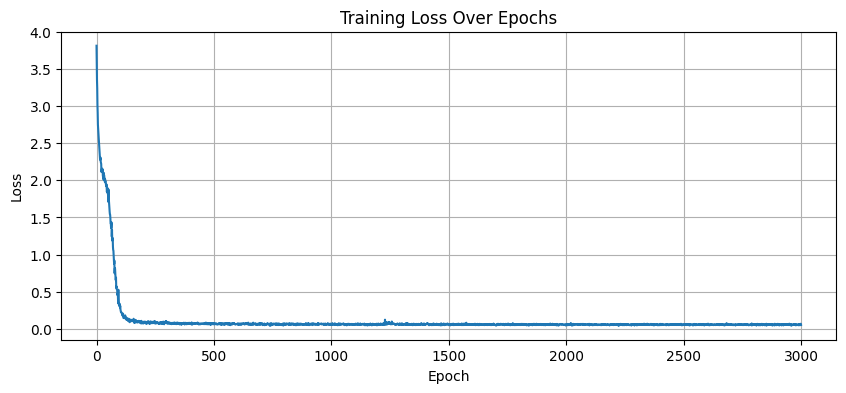

In [17]:
print(f"\n--- Starting Training Loop for {epochs} epochs ---")

# List to track losses
losses = []

# Training loop
for epoch in range(epochs):

    # --- 1. Batch Selection ---
    # Select random indices for the batch
    indices = torch.randint(0, num_sequences_available, (batch_size,))
    # Get input and target sequences and move to device
    xb = train_x[indices].to(device) # Input batch shape: (B, T)
    yb = train_y[indices].to(device) # Target batch shape: (B, T)

    # --- 2. Forward Pass (Inline execution) ---
    B, T = xb.shape # B = batch_size, T = block_size
    C = d_model     # Embedding dimension

    # --- Initial Embedding ---
    token_embed = token_embedding_table(xb) # (B, T, C)

    # --- Prepare RoPE Frequencies for this batch/sequence length ---
    # Create position IDs (0 to T-1)
    position_ids = torch.arange(T, device=device).unsqueeze(0) # Shape: (1, T)
    # Expand inv_freq for batch and sequence length
    # inv_freq shape: (d_k/2) -> (1, d_k/2, 1) -> (B, d_k/2, 1)
    inv_freq_expanded = inv_freq.unsqueeze(0).unsqueeze(-1).expand(B, -1, 1)
    # position_ids shape: (1, T) -> (B, 1, T)
    pos_ids_expanded = position_ids.expand(B, -1).unsqueeze(1).float()
    # Calculate frequencies: (B, d_k/2, 1) @ (B, 1, T) -> (B, d_k/2, T)
    with torch.autocast(device_type=device, enabled=False): # RoPE often done in float32
        freqs = (inv_freq_expanded.float() @ pos_ids_expanded).transpose(1, 2) # (B, T, d_k/2)
        # Convert to complex numbers (cis format: cos + i*sin)
        freqs_cis = torch.polar(torch.ones_like(freqs), freqs) # (B, T, d_k/2)

    # We don't add positional encoding directly; RoPE is applied in attention
    x = token_embed

    # --- Transformer Blocks Loop ---
    for i in range(n_layers):
        # Residual connection starts here
        residual_attn = x

        # --- Input RMSNorm ---
        # Formula: x * rsqrt(mean(x^2) + eps) * gamma
        x_float = x.float()
        norm_const = torch.rsqrt(x_float.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
        x_norm = (x_float * norm_const).type_as(x)
        x_norm = x_norm * rmsnorm_weights_input[i]

        # --- Multi-Head Attention (MHA) ---
        # QKV projection
        qkv = mha_qkv_linears[i](x_norm) # (B, T, 3*C)
        # Split heads
        qkv = qkv.view(B, T, n_heads, 3 * d_k) # Reshape before permute
        # Split Q, K, V
        q, k, v = qkv.chunk(3, dim=-1) # (B, T, n_heads, d_k)

        # --- Apply RoPE ---
        # Inline apply_rotary_emb logic
        # Reshape Q, K for complex multiplication: (B, T, n_heads, d_k/2, 2)
        q_rope = q.float().reshape(B, T, n_heads, -1, 2)
        k_rope = k.float().reshape(B, T, n_heads, -1, 2)
        # View as complex: (B, T, n_heads, d_k/2)
        q_complex = torch.view_as_complex(q_rope)
        k_complex = torch.view_as_complex(k_rope)
        # Reshape freqs_cis for broadcasting: (B, T, 1, d_k/2)
        freqs_cis_bthd = freqs_cis.unsqueeze(2)
        # Apply rotation
        q_rotated = q_complex * freqs_cis_bthd
        k_rotated = k_complex * freqs_cis_bthd
        # Convert back to real: (B, T, n_heads, d_k/2, 2)
        q_out_real = torch.view_as_real(q_rotated)
        k_out_real = torch.view_as_real(k_rotated)
        # Flatten last two dimensions: (B, T, n_heads, d_k)
        q = q_out_real.flatten(3).type_as(q)
        k = k_out_real.flatten(3).type_as(k)

        # Permute for attention calculation: (B, n_heads, T, d_k)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3) # Permute v as well

        # Scaled dot-product attention
        # (B, n_heads, T, d_k) @ (B, n_heads, d_k, T) -> (B, n_heads, T, T)
        attn_scores = (q @ k.transpose(-2, -1)) * (d_k ** -0.5)
        # Apply Causal Mask
        attn_scores = attn_scores.masked_fill(causal_mask[:,:,:T,:T] == 0, float('-inf'))
        attention_weights = F.softmax(attn_scores, dim=-1) # (B, n_heads, T, T)
        # Handle potential NaNs if a row in softmax is all -inf (e.g., first token)
        attention_weights = torch.nan_to_num(attention_weights)

        # Attention output
        # (B, n_heads, T, T) @ (B, n_heads, T, d_k) -> (B, n_heads, T, d_k)
        attn_output = attention_weights @ v
        # Concatenate heads: -> (B, T, n_heads, d_k) -> (B, T, C)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(B, T, C)

        # Output projection
        attn_output = mha_output_linears[i](attn_output)

        # --- Add Residual Connection (Attention) ---
        x = residual_attn + attn_output

        # --- MoE Block ---
        # Residual connection starts here
        residual_moe = x

        # --- Post-Attention RMSNorm ---
        x_float = x.float()
        norm_const = torch.rsqrt(x_float.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
        x_norm = (x_float * norm_const).type_as(x)
        x_norm = x_norm * rmsnorm_weights_post_attn[i]

        # --- Router Logits ---
        # Input x_norm: (B, T, C) -> Router Output: (B, T, num_experts)
        router_logits = moe_routers[i](x_norm)

        # --- Expert Selection (Top-K) ---
        # Get top-k experts and their routing weights (logits)
        routing_weights, selected_experts = torch.topk(router_logits, num_experts_per_tok, dim=-1)
        # Apply sigmoid to make weights sum to <= k (treating experts independently)
        # Or use Softmax if weights should sum to 1 across the k experts
        # Reference script uses sigmoid: B, T, k
        routing_weights = torch.sigmoid(routing_weights)

        # --- Prepare for Expert Calculation ---
        # Flatten B and T dimensions to treat each token independently
        x_flat = x_norm.view(-1, C) # (B*T, C)
        selected_experts_flat = selected_experts.view(-1) # (B*T*k)
        routing_weights_flat = routing_weights.view(-1)   # (B*T*k)

        # Create token indices corresponding to the selected experts
        # token_idx goes from 0 to B*T-1
        # expert_idx is the index of the expert selected (0 to num_experts-1)
        token_idx = torch.arange(B * T, device=device).repeat_interleave(num_experts_per_tok) # (B*T*k)
        expert_idx = selected_experts_flat # (B*T*k)

        # Gather the hidden states for each token * expert combination
        # Input x_flat: (B*T, C)
        # Index token_idx: (B*T*k)
        # Output expert_inputs: (B*T*k, C)
        expert_inputs = x_flat[token_idx]

        # --- Run Experts ---
        # Get expert weights for the selected experts
        # moe_expert_gate_up_proj[i]: (num_experts, C, 2*expert_dim)
        # Index expert_idx: (B*T*k)
        # Output gate_up_w_selected: (B*T*k, C, 2*expert_dim)
        gate_up_w_selected = moe_expert_gate_up_proj[i][expert_idx]
        # moe_expert_down_proj[i]: (num_experts, expert_dim, C)
        # Output down_w_selected: (B*T*k, expert_dim, C)
        down_w_selected = moe_expert_down_proj[i][expert_idx]

        # Perform batched matrix multiplication (BMM)
        # expert_inputs: (B*T*k, C) -> unsqueeze for BMM: (B*T*k, 1, C)
        # gate_up_w_selected: (B*T*k, C, 2*expert_dim)
        # Output gate_up_states: (B*T*k, 1, 2*expert_dim)
        gate_up_states = torch.bmm(expert_inputs.unsqueeze(1), gate_up_w_selected)

        # Split gate and up states
        gate, up = gate_up_states.chunk(2, dim=-1) # Each: (B*T*k, 1, expert_dim)

        # Apply activation function (SiLU) and gating
        activated_states = activation_fn(gate) * up # (B*T*k, 1, expert_dim)

        # Down projection
        # activated_states: (B*T*k, 1, expert_dim)
        # down_w_selected: (B*T*k, expert_dim, C)
        # Output expert_outputs_flat: (B*T*k, 1, C) -> squeeze -> (B*T*k, C)
        expert_outputs_flat = torch.bmm(activated_states, down_w_selected).squeeze(1) # (B*T*k, C)

        # Weight the outputs by the routing weights
        # expert_outputs_flat: (B*T*k, C)
        # routing_weights_flat: (B*T*k) -> unsqueeze -> (B*T*k, 1)
        expert_outputs_weighted = expert_outputs_flat * routing_weights_flat.unsqueeze(-1) # (B*T*k, C)

        # --- Combine Expert Outputs ---
        # Sum the outputs for each token (across the k selected experts)
        # Need to scatter-add the weighted outputs back to the original token positions
        # Initialize output tensor: (B*T, C)
        combined_expert_outputs = torch.zeros_like(x_flat) # (B*T, C)
        # Scatter Add:
        # combined_expert_outputs: tensor to add into
        # dim=0: dimension along which to index
        # index=token_idx.unsqueeze(-1).expand(-1, C): indices to scatter to (needs C dimension)
        # src=expert_outputs_weighted: values to add
        combined_expert_outputs.scatter_add_(0, token_idx.unsqueeze(-1).expand(-1, C), expert_outputs_weighted)

        # --- Run Shared Expert ---
        shared_gate_val = shared_expert_gate_proj[i](x_norm) # (B, T, shared_expert_dim)
        shared_up_val = shared_expert_up_proj[i](x_norm)     # (B, T, shared_expert_dim)
        shared_activated = activation_fn(shared_gate_val) * shared_up_val # (B, T, shared_expert_dim)
        shared_output = shared_expert_down_proj[i](shared_activated)      # (B, T, C)

        # --- Combine MoE and Shared Expert ---
        # Reshape combined_expert_outputs back to (B, T, C)
        moe_output = combined_expert_outputs.view(B, T, C)
        # Add shared expert output
        final_moe_output = moe_output + shared_output

        # --- Add Residual Connection (MoE/FFN) ---
        x = residual_moe + final_moe_output

    # --- Final RMSNorm ---
    x_float = x.float()
    norm_const = torch.rsqrt(x_float.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
    x_norm = (x_float * norm_const).type_as(x)
    x_norm = x_norm * final_rmsnorm_weight

    # --- Final Output Layer ---
    logits = output_linear_layer(x_norm) # (B, T, vocab_size)

    # --- 3. Calculate Loss ---
    B_loss, T_loss, V_loss = logits.shape
    logits_for_loss = logits.view(B_loss * T_loss, V_loss)
    targets_for_loss = yb.view(B_loss * T_loss)
    loss = criterion(logits_for_loss, targets_for_loss)

    # --- 4. Zero Gradients ---
    optimizer.zero_grad()

    # --- 5. Backward Pass ---
    loss.backward()

    # --- 6. Update Parameters ---
    optimizer.step()

    # --- Logging ---
    current_loss = loss.item()
    losses.append(current_loss)
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        print(f"  Epoch {epoch+1}/{epochs}, Loss: {current_loss:.4f}")

print("--- Training Loop Completed ---")

# Optional: Plot losses
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
except ImportError:
    print("Matplotlib not found, skipping loss plot.")

**Output Explanation:** This crucial block executes the training. For each epoch, it:
1.  Selects a batch of input (`xb`) and target (`yb`) sequences.
2.  Performs the full forward pass:
    *   Embeds tokens.
    *   Calculates RoPE frequencies (`freqs_cis`).
    *   Iterates through `n_layers`:
        *   Applies input RMSNorm.
        *   Calculates Multi-Head Attention, including applying RoPE to queries and keys.
        *   Adds the first residual connection.
        *   Applies post-attention RMSNorm.
        *   Executes the MoE logic: routing, expert selection (`topk`), weighted gathering, expert processing (gated MLP via BMM), shared expert processing, combination (`scatter_add_`), and addition.
        *   Adds the second residual connection.
    *   Applies final RMSNorm.
    *   Projects to vocabulary logits.
3.  Calculates the Cross-Entropy loss between the predicted logits and the actual target tokens.
4.  Performs backpropagation to compute gradients.
5.  Updates the model parameters using the optimizer.
The output shows the loss value printed periodically, which should generally decrease over time, indicating that the model is learning.

### Step 7: Text Generation (Inline)

**Goal:** Use the trained model parameters to generate new text autoregressively, starting from a seed context.

#### Step 7.1: Generation Setup

**Theory:** Define the starting prompt (seed characters), convert it to token IDs, and specify how many new tokens to generate. Crucially, set all model components to evaluation mode (`.eval()`) - although less critical here as we didn't use dropout/batchnorm, it's vital practice. We also use `torch.no_grad()` to disable gradient calculation for efficiency during inference.

In [18]:
print("\n--- Step 7: Text Generation ---")

# --- Generation Parameters ---
seed_chars = "Alice " # Starting text prompt
num_tokens_to_generate = 200 # How many new characters to generate
print(f"Seed text: '{seed_chars}'")
print(f"Generating {num_tokens_to_generate} new tokens...")

# --- Prepare Initial Context ---
# Convert seed characters to token IDs
seed_ids = [char_to_int[ch] for ch in seed_chars if ch in char_to_int]
# Create the initial context tensor (add batch dimension)
generated_sequence = torch.tensor([seed_ids], dtype=torch.long, device=device)
print(f"Initial context shape: {generated_sequence.shape}")

# --- Set Model Components to Evaluation Mode ---
# (Important if Dropout or BatchNorm were used, good practice anyway)
token_embedding_table.eval()
for i in range(n_layers):
    # RMSNorm doesn't have eval mode, just use weights
    mha_qkv_linears[i].eval()
    mha_output_linears[i].eval()
    moe_routers[i].eval()
    # Expert weights (Parameters) don't have eval()
    shared_expert_gate_proj[i].eval()
    shared_expert_up_proj[i].eval()
    shared_expert_down_proj[i].eval()
output_linear_layer.eval()
# Final RMSNorm weight doesn't have eval()
print("Model components set to evaluation mode (where applicable).")


--- Step 7: Text Generation ---
Seed text: 'Alice '
Generating 200 new tokens...
Initial context shape: torch.Size([1, 6])
Model components set to evaluation mode (where applicable).


**Output Explanation:** Sets the seed text and the desired generation length. It converts the seed text into token IDs and prepares the initial context tensor. It also explicitly sets the relevant `nn.Module` components (like Linear layers) to evaluation mode.

#### Step 7.2: The Generation Loop

**Theory:** Generate text token by token:
1.  Take the current generated sequence (or the last `block_size` tokens of it) as context.
2.  Perform a forward pass through the model (using the same inline logic as training) to get logits for the *next* token.
3.  Convert the logits for the very last position into probabilities using Softmax.
4.  Sample the next token ID from this probability distribution (using `torch.multinomial`).
5.  Append the sampled token ID to the sequence.
6.  Repeat until the desired number of tokens is generated.

In [19]:
print("Starting generation loop...")
# Disable gradient calculations
with torch.no_grad():
    for _ in range(num_tokens_to_generate):
        # --- 1. Prepare Input Context ---
        # Ensure context doesn't exceed block_size
        current_context = generated_sequence[:, -block_size:]
        B_gen, T_gen = current_context.shape
        C_gen = d_model

        # --- 2. Forward Pass (Identical logic to training loop's forward pass) ---
        # --- Initial Embedding ---
        token_embed_gen = token_embedding_table(current_context) # (B_gen, T_gen, C_gen)
        # --- Prepare RoPE Frequencies ---
        position_ids_gen = torch.arange(T_gen, device=device).unsqueeze(0) # (1, T_gen)
        inv_freq_expanded_gen = inv_freq.unsqueeze(0).unsqueeze(-1).expand(B_gen, -1, 1)
        pos_ids_expanded_gen = position_ids_gen.expand(B_gen, -1).unsqueeze(1).float()
        with torch.autocast(device_type=device, enabled=False):
            freqs_gen = (inv_freq_expanded_gen.float() @ pos_ids_expanded_gen).transpose(1, 2)
            freqs_cis_gen = torch.polar(torch.ones_like(freqs_gen), freqs_gen)
        x_gen = token_embed_gen

        # --- Transformer Blocks Loop ---
        for i in range(n_layers):
            residual_attn_gen = x_gen
            # --- Input RMSNorm ---
            x_float_gen = x_gen.float()
            norm_const_gen = torch.rsqrt(x_float_gen.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
            x_norm_gen = (x_float_gen * norm_const_gen).type_as(x_gen)
            x_norm_gen = x_norm_gen * rmsnorm_weights_input[i]
            # --- MHA ---
            qkv_gen = mha_qkv_linears[i](x_norm_gen)
            qkv_gen = qkv_gen.view(B_gen, T_gen, n_heads, 3 * d_k)
            q_gen, k_gen, v_gen = qkv_gen.chunk(3, dim=-1)
            # --- Apply RoPE ---
            q_rope_gen = q_gen.float().reshape(B_gen, T_gen, n_heads, -1, 2)
            k_rope_gen = k_gen.float().reshape(B_gen, T_gen, n_heads, -1, 2)
            q_complex_gen = torch.view_as_complex(q_rope_gen)
            k_complex_gen = torch.view_as_complex(k_rope_gen)
            freqs_cis_bthd_gen = freqs_cis_gen.unsqueeze(2)
            q_rotated_gen = q_complex_gen * freqs_cis_bthd_gen
            k_rotated_gen = k_complex_gen * freqs_cis_bthd_gen
            q_out_real_gen = torch.view_as_real(q_rotated_gen)
            k_out_real_gen = torch.view_as_real(k_rotated_gen)
            q_gen = q_out_real_gen.flatten(3).type_as(q_gen)
            k_gen = k_out_real_gen.flatten(3).type_as(k_gen)
            # --- Attention Calculation ---
            q_gen = q_gen.permute(0, 2, 1, 3)
            k_gen = k_gen.permute(0, 2, 1, 3)
            v_gen = v_gen.permute(0, 2, 1, 3)
            attn_scores_gen = (q_gen @ k_gen.transpose(-2, -1)) * (d_k ** -0.5)
            # Use causal mask sliced to T_gen
            attn_scores_gen = attn_scores_gen.masked_fill(causal_mask[:,:,:T_gen,:T_gen] == 0, float('-inf'))
            attention_weights_gen = F.softmax(attn_scores_gen, dim=-1)
            attention_weights_gen = torch.nan_to_num(attention_weights_gen)
            attn_output_gen = attention_weights_gen @ v_gen
            attn_output_gen = attn_output_gen.permute(0, 2, 1, 3).contiguous().view(B_gen, T_gen, C_gen)
            attn_output_gen = mha_output_linears[i](attn_output_gen)
            # --- Add Residual 1 ---
            x_gen = residual_attn_gen + attn_output_gen
            # --- MoE Block ---
            residual_moe_gen = x_gen
            # --- Post-Attention RMSNorm ---
            x_float_gen = x_gen.float()
            norm_const_gen = torch.rsqrt(x_float_gen.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
            x_norm_gen = (x_float_gen * norm_const_gen).type_as(x_gen)
            x_norm_gen = x_norm_gen * rmsnorm_weights_post_attn[i]
            # --- Router, Experts, Shared (Inline MoE logic from training loop) ---
            router_logits_gen = moe_routers[i](x_norm_gen)
            routing_weights_gen, selected_experts_gen = torch.topk(router_logits_gen, num_experts_per_tok, dim=-1)
            routing_weights_gen = torch.sigmoid(routing_weights_gen)
            x_flat_gen = x_norm_gen.view(-1, C_gen)
            selected_experts_flat_gen = selected_experts_gen.view(-1)
            routing_weights_flat_gen = routing_weights_gen.view(-1)
            token_idx_gen = torch.arange(B_gen * T_gen, device=device).repeat_interleave(num_experts_per_tok)
            expert_idx_gen = selected_experts_flat_gen
            expert_inputs_gen = x_flat_gen[token_idx_gen]
            gate_up_w_selected_gen = moe_expert_gate_up_proj[i][expert_idx_gen]
            down_w_selected_gen = moe_expert_down_proj[i][expert_idx_gen]
            gate_up_states_gen = torch.bmm(expert_inputs_gen.unsqueeze(1), gate_up_w_selected_gen)
            gate_gen, up_gen = gate_up_states_gen.chunk(2, dim=-1)
            activated_states_gen = activation_fn(gate_gen) * up_gen
            expert_outputs_flat_gen = torch.bmm(activated_states_gen, down_w_selected_gen).squeeze(1)
            expert_outputs_weighted_gen = expert_outputs_flat_gen * routing_weights_flat_gen.unsqueeze(-1)
            combined_expert_outputs_gen = torch.zeros_like(x_flat_gen)
            combined_expert_outputs_gen.scatter_add_(0, token_idx_gen.unsqueeze(-1).expand(-1, C_gen), expert_outputs_weighted_gen)
            shared_gate_val_gen = shared_expert_gate_proj[i](x_norm_gen)
            shared_up_val_gen = shared_expert_up_proj[i](x_norm_gen)
            shared_activated_gen = activation_fn(shared_gate_val_gen) * shared_up_val_gen
            shared_output_gen = shared_expert_down_proj[i](shared_activated_gen)
            moe_output_gen = combined_expert_outputs_gen.view(B_gen, T_gen, C_gen)
            final_moe_output_gen = moe_output_gen + shared_output_gen
            # --- Add Residual 2 ---
            x_gen = residual_moe_gen + final_moe_output_gen

        # --- Final RMSNorm ---
        x_float_gen = x_gen.float()
        norm_const_gen = torch.rsqrt(x_float_gen.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
        x_norm_gen = (x_float_gen * norm_const_gen).type_as(x_gen)
        x_norm_gen = x_norm_gen * final_rmsnorm_weight

        # --- Final Output Layer ---
        logits_gen = output_linear_layer(x_norm_gen) # (B_gen, T_gen, vocab_size)

        # --- 3. Get Logits for Last Time Step ---
        logits_last_token = logits_gen[:, -1, :] # Shape: (B_gen, vocab_size)

        # --- 4. Apply Softmax ---
        probs = F.softmax(logits_last_token, dim=-1) # Shape: (B_gen, vocab_size)

        # --- 5. Sample Next Token ---
        next_token = torch.multinomial(probs, num_samples=1) # Shape: (B_gen, 1)

        # --- 6. Append Sampled Token ---
        generated_sequence = torch.cat((generated_sequence, next_token), dim=1)

print("...Generation loop finished.")

Starting generation loop...
...Generation loop finished.


**Output Explanation:** This block performs the actual text generation. It iteratively feeds the current sequence into the model, gets the probability distribution for the next token, samples from it, and appends the result. The output confirms the loop has started and finished.

#### Step 7.3: Decode Generated Sequence

**Theory:** Convert the final sequence of generated token IDs (including the initial seed) back into a human-readable string using the `int_to_char` mapping.

In [20]:
# Get the generated sequence for the first (and only) batch item
final_generated_ids = generated_sequence[0].tolist()

# Decode the list of IDs back into a string
decoded_text = ''.join([int_to_char.get(id_val, '[UNK]') for id_val in final_generated_ids])

print("\n--- Final Generated Text ---")
print(decoded_text)


--- Final Generated Text ---
Alice 'without pictures or
conversation?'
So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure
of making a daisy-chain wo


**Output Explanation:** Takes the final tensor of generated token IDs, converts it back into a list of integers, and uses the `int_to_char` dictionary to map each ID back to its corresponding character. The resulting characters are joined to form the final generated text string, which is then printed.

### Step 8: Save Model State (Optional)

**Goal:** Save the trained parameters of the model to a file for later use.

In [21]:
# Create a directory to store the model (if it doesn't exist)
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'llama4_moe_model.pt')

# Create a state dictionary manually collecting all components
model_state = {
    # Configuration
    'config': {
        'vocab_size': vocab_size,
        'd_model': d_model,
        'n_layers': n_layers,
        'n_heads': n_heads,
        'block_size': block_size,
        'rms_norm_eps': rms_norm_eps,
        'rope_theta': rope_theta,
        'num_local_experts': num_local_experts,
        'num_experts_per_tok': num_experts_per_tok,
        'intermediate_size_expert': intermediate_size_expert,
        'intermediate_size_shared': intermediate_size_shared
    },
    # Tokenizer
    'tokenizer': {
        'char_to_int': char_to_int,
        'int_to_char': int_to_char
    },
    # Model Parameters (State Dicts for nn.Modules, Tensors for nn.Parameters)
    'token_embedding_table': token_embedding_table.state_dict(),
    'rmsnorm_weights_input': rmsnorm_weights_input, # List of Parameters
    'rmsnorm_weights_post_attn': rmsnorm_weights_post_attn, # List of Parameters
    'final_rmsnorm_weight': final_rmsnorm_weight, # Parameter
    'mha_qkv_linears': [l.state_dict() for l in mha_qkv_linears],
    'mha_output_linears': [l.state_dict() for l in mha_output_linears],
    'moe_routers': [r.state_dict() for r in moe_routers],
    'moe_expert_gate_up_proj': moe_expert_gate_up_proj, # List of Parameters
    'moe_expert_down_proj': moe_expert_down_proj, # List of Parameters
    'shared_expert_gate_proj': [l.state_dict() for l in shared_expert_gate_proj],
    'shared_expert_up_proj': [l.state_dict() for l in shared_expert_up_proj],
    'shared_expert_down_proj': [l.state_dict() for l in shared_expert_down_proj],
    'output_linear_layer': output_linear_layer.state_dict(),
    # Note: RoPE inv_freq is not saved as it's derived from config
}

# Save the state dictionary
torch.save(model_state, save_path)

print(f"Model state saved successfully to '{save_path}'")

Model state saved successfully to 'saved_models/llama4_moe_model.pt'


**Output Explanation:** This block gathers the configuration, tokenizer, and the state of all learnable parameters (weights from `nn.Linear`, `nn.Embedding`, and the explicit `nn.Parameter` tensors for RMSNorm and Experts) into a Python dictionary. It then uses `torch.save` to serialize this dictionary to a file (`.pt`). The output confirms that the model state has been saved.

### Step 9: Conclusion

This notebook provided an extremely detailed, step-by-step, inline implementation of a Transformer-based language model incorporating key architectural elements inspired by models like Llama 4, particularly **Mixture-of-Experts (MoE)**, **RMS Normalization**, and **Rotary Positional Embeddings (RoPE)**.

We covered:
1.  **Setup & Tokenization:** Basic environment setup and character-level tokenization.
2.  **Hyperparameter Definition:** Setting up configuration values, scaled down from larger models.
3.  **Data Preparation:** Creating input/target sequences for next-token prediction.
4.  **Model Initialization (Inline):** Explicitly creating and initializing components like token embeddings, RMSNorm weights, attention linear layers, RoPE frequency bases, MoE routers, MoE expert weights, shared expert MLPs, and the final output layer.
5.  **Training Loop (Inline):** Implementing the complete forward pass within the loop, demonstrating:
    *   Application of RMSNorm.
    *   Calculation and application of RoPE within the MHA block.
    *   The MoE forward pass: routing, expert selection (Top-K), parallel expert computation (using BMM), combination of expert outputs (`scatter_add_`), and integration with a shared expert MLP.
    *   Standard Transformer operations like residual connections and attention.
    *   Loss calculation, backpropagation, and optimizer steps.
6.  **Text Generation:** Implementing autoregressive sampling using the trained model components in evaluation mode.

While highly verbose and simplified in scale and certain features (like using MHA instead of GQA), this inline approach aimed to demystify the core mechanics, especially the MoE layer's operation (routing, expert processing, combination) and its integration within a modern Transformer architecture incorporating RMSNorm and RoPE. Building upon this understanding would involve using more structured code (functions, classes), implementing further optimizations (GQA, etc.), and training on significantly larger datasets.